# Análisis para tienda online
## Objetivo:
Análisis de hipótesis para el aumento de ingresos
### Objetivos específicos:
* Priorizar las hipótesis
* Analizar el test A/B
    * Ingreso acumudalo por grupo
    * Número de pedidos por grupo
    * Tamaño de pedido promedio por grupo y su diferencia relativa
    * Tasa de conversión para cada grupo
    * Identificar anomalías
    * Significancia estadística de la diferencia en la tasa de conversión y el ticket promedio para cada grupo


## Pasos a seguir
1. Priorizar las hipótesis
    * Aplicar framework ICE
    * Aplicar framework RICE

2. Análisis de test A/B
    * Limpieza de datos
    * Ingreso acumudalo por grupo
    * Número de pedidos por grupo
    * Tamaño de pedido promedio por grupo y su diferencia relativa
    * Tasa de conversión para cada grupo
    * Identificar anomalías
    * Significancia estadística de la diferencia en la tasa de conversión y el ticket promedio para cada grupo

3. Toma de decisión sobre la prueba

## Diccionario de datos

**Hypotheses** (hipótesis)
* ``Hypotheses``: breves descripciones de las hipótesis
* ``Reach``: alcance del usuario, en una escala del uno a diez
* ``Impact``: impacto en los usuarios, en una escala del uno al diez
* ``Confidence``: confianza en la hipótesis, en una escala del uno al diez
* ``Effort``: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba

**Orders** (pedidos realizados)
* ``transactionId``: identificador de pedido
* ``visitorId``: identificador del usuario que realizó el pedido
* ``date``: fecha del pedido
* ``revenue``: ingresos del pedido
* ``group``: el grupo del test A/B al que pertenece el usuario

**Visits** (registro de visitas)
* ``date``: la fecha
* ``group``: grupo de la prueba A/B
* ``visits``: el número de visitas en la fecha especificada en el grupo de pruebas A/B especificado

In [1]:
# importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# Priorizar hipótesis

In [2]:
# importar hipótesis
hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')

# información general de 'hypotheses'
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [3]:
# nombres de columnas
hypotheses.columns = hypotheses.columns.str.lower()

In [4]:
# mostrar hipótesis
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [5]:
# elaborar frameworks
# calcular 'ICE'
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

# calcular 'RICE'
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

In [6]:
# prioridad de las hipótesis
print('Framework ICE', '\n', hypotheses[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))
print()
print('Framework RICE', '\n', hypotheses[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

Framework ICE 
                                           hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000

Framework RICE 
                                           hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that

### Comentario
Hay una diferencia en la priorización de las hipótesis dependiendo del framework empleado, esto se debe al parámetro 'reach' que emplea el 'RICE'. Sugiero priorizar las hipótesis tomando en cuenta ambos métodos para considerar tanto el impacto como el alcance.

Hipótesis recomendadas por orden de prioridad:
1) hipótesis 8: Add a subscription form to all the main pages. This will help you compile a mailing list
2) hipótesis 1: Add two new channels for attracting traffic. This will bring 30% more users
3) hipótesis 3: Add product recommendation blocks to the store's site. This will increase conversion and average purchase size

# Análisis de test A/B

In [7]:
# importar datasets
orders = pd.read_csv('orders_us.csv')
visits = pd.read_csv('visits_us.csv')

## visualización general de los datos

In [8]:
# información general de 'orders'
orders.info()
print('\n', 'Valores duplicados:', orders.duplicated().sum())
print('\n', orders.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB

 Valores duplicados: 0

       transactionId   visitorId        date  revenue group
427      3019510679  2397843657  2019-08-19     25.5     B
227      4267573899  2038680547  2019-08-17     55.4     A
1140     3513553494   583902904  2019-08-13     40.2     A
678      3614621763  3977396102  2019-08-20     30.0     B
991       465243102   451104171  2019-08-28      5.8     B


In [9]:
# información general de 'visits'
visits.info()
print('\n', 'Valores duplicados:', visits.duplicated().sum())
print('\n', visits.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

 Valores duplicados: 0

           date group  visits
60  2019-08-30     B     490
61  2019-08-31     B     718
47  2019-08-17     B     421
45  2019-08-15     B     544
49  2019-08-19     B     487


### Comentario
Los datasets no presentan valores nulos ni duplicados. Hay que darle formato al nombre de las columnas del df 'orders' y convertir la columna 'date' de ambos df's al formato adecuado.

## Limpieza de datos

In [10]:
# formatear nombres de columnas de 'orders'
orders.columns = orders.columns.str.lower()
orders.rename(columns={'transactionid':'transaction_id', 'visitorid':'visitor_id'}, inplace=True)

# conversión de columnas 'date'
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

## Análisis de resultados

In [11]:
print('Inicio de la prueba:', orders['date'].min())
print('Fecha corte:', orders['date'].max())

Inicio de la prueba: 2019-08-01 00:00:00
Fecha corte: 2019-08-31 00:00:00


In [12]:
# lista de usuarios
users_group_a = orders[orders['group'] == 'A']['visitor_id'].unique()
users_group_b = orders[orders['group'] == 'B']['visitor_id'].unique()
# tamaño de grupos
print('Tamaño grupo A:', len(users_group_a))
print('Tamaño grupo B:', len(users_group_b))

Tamaño grupo A: 503
Tamaño grupo B: 586


In [13]:
# usuarios en común grupo A y B
common_users = np.intersect1d(users_group_a, users_group_b)
print('Usuarios en ambos grupos:', len(common_users))

Usuarios en ambos grupos: 58


### Comentario
Se encontraron 58 usuarios repetidos en ambos grupos. Se sugiere confirmar cómo es que fue llevada a cabo la prueba para identificar si son usuarios que pueden permanecer en ambos grupos (p. ej. 15 días permanecieron en "A" y 15 días permanecieron en "B") o hubo algún fallo y fueron usuarios que saltaron de un grupo a otro repentinamente.

Por lo pronto estos usuarios serán eliminados hasta confirmarlo.

In [14]:
# filtrar 'orders' sin usuarios duplicados
filtered_orders = orders[np.logical_not(orders['visitor_id'].isin(common_users))]

# usuarios por grupo
# lista de usuarios
users_group_a = filtered_orders[filtered_orders['group'] == 'A']['visitor_id'].unique()
users_group_b = filtered_orders[filtered_orders['group'] == 'B']['visitor_id'].unique()
# tamaño de grupos
print('Tamaño grupo A:', len(users_group_a))
print('Tamaño grupo B:', len(users_group_b))

Tamaño grupo A: 445
Tamaño grupo B: 528


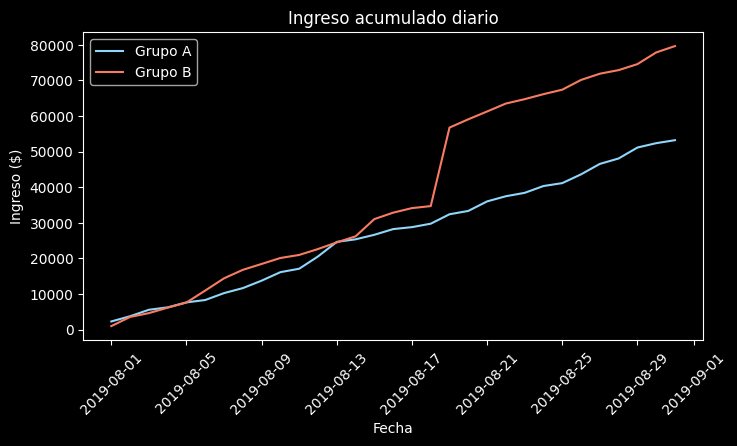

In [15]:
# ingreso acumulado diario por grupo
# dataframe ingresos acumulados diarios
daily_cumulative_revenue = filtered_orders.groupby(['group', 'date'], as_index=False)['revenue'].sum()

# ordenar cronológicamente
daily_cumulative_revenue = daily_cumulative_revenue.sort_values(['group', 'date'])

# calcular ingreso acumulado diario
daily_cumulative_revenue['cumulative_revenue'] = daily_cumulative_revenue.groupby('group')['revenue'].cumsum()

# gráfico de líneas: ingreso acumulado diario
plt.style.use('dark_background')
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = daily_cumulative_revenue[daily_cumulative_revenue['group'] == grp]
    plt.plot(grp_data['date'], grp_data['cumulative_revenue'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Ingreso acumulado diario')
plt.xlabel('Fecha')
plt.ylabel('Ingreso ($)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Comentario
El grupo "B", posterior al día 5, mostró tener mayores ingresos y para el día 19 tuvo un ingreso exponencial. Esto debe de ser tomado en cuenta para posteriores análisis por la presencia de _outliers_ que pueden distorcionar los resultados.

En contraste, el grupo "A" mantuvo un crecimiento constante sin la aparente presencia de incrementos repentinos.

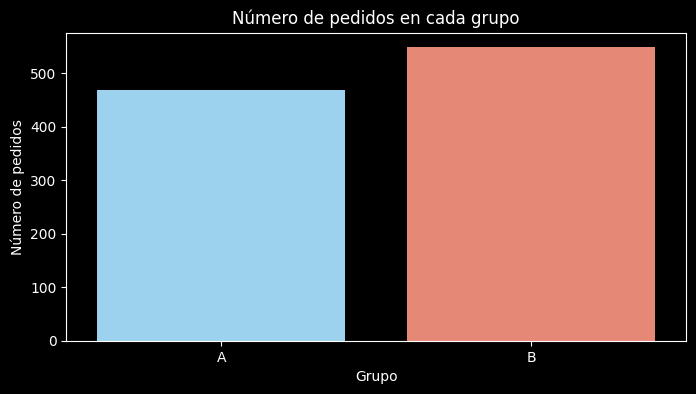

In [16]:
# número de pedidos por grupo
orders_per_group = filtered_orders.groupby('group', as_index=False)['transaction_id'].nunique()
orders_per_group.rename(columns={'transaction_id':'num_orders'}, inplace=True)

# gráfico de barras: número de pedidos por grupo
plt.figure(figsize=(8,4))
sns.barplot(orders_per_group,
            x='group',
            y='num_orders',
            hue='group',
            palette={'A': '#8FD6FA', 'B': '#F87C63'})
plt.title('Número de pedidos en cada grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de pedidos')
plt.show()

### Comentarios
El grupo "B" tuvo mayor número de pedidos, esta diferencia de 80 órdenes puede ser un indicio de que algo incite al grupo "B" a realizar más compras. 

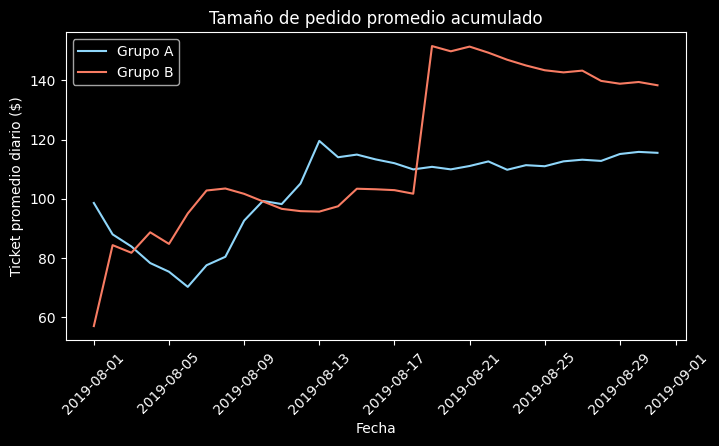

In [17]:
# tamaño de pedido promedio
# dataframe tamaño de pedido promedio diario
daily_cumulative_avg = filtered_orders.groupby(['group', 'date'], as_index=False)['revenue'].mean()

# ordenar cronológicamente
daily_cumulative_avg = daily_cumulative_avg.sort_values(by=['group', 'date'])

# calcular 'AOV'
daily_cumulative_avg['AOV'] = daily_cumulative_avg.groupby('group')['revenue'].transform(lambda x: x.expanding().mean())

# gráfico de líneas: tamaño de pedido promedio acumulado
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = daily_cumulative_avg[daily_cumulative_avg['group'] == grp]
    plt.plot(grp_data['date'], grp_data['AOV'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Tamaño de pedido promedio acumulado')
plt.xlabel('Fecha')
plt.ylabel('Ticket promedio diario ($)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Comentario
El grupo "B" a partit del día 4  empieza a tener un incremento en el tamaño promedio y es hasta el día 19 que tiene un notable aumento (nuevamente señalando la presencia de _outliers_) en el ticket promedio diario y supera al grupo "A". Sin embargo, días después empieza a disminuir gradualmente.

En contraste, aunque el grupo "B" había superado al grupo "A" a partir del día 4, el grupo "A" rápidamente comenzó a incrementar hasta que a partir del día 14 se comenzó a estabilizar y posterior al día 29 el ticket promedio se mantenía en torno a $115.

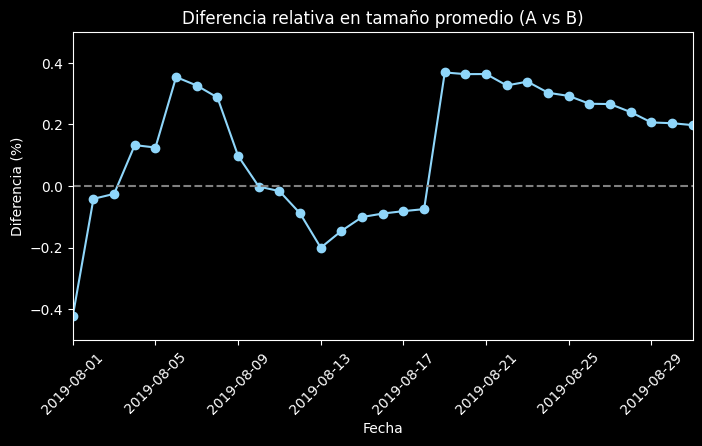

In [18]:
# diferencia relativa en el tamaño de pedido promedio
# tabla dinámica del 'AOV' por grupo
diff_relative_aov = daily_cumulative_avg.pivot(
    index='date',
    columns='group',
    values='AOV',
).reset_index()

# calcular la diferencia relativa
diff_relative_aov ['diff_relative'] = (diff_relative_aov['B'] - diff_relative_aov['A']) / diff_relative_aov['A']

# gráfico de líneas: diferencia relativa en tamaño promedio
plt.figure(figsize=(8,4))
plt.plot(diff_relative_aov['date'], diff_relative_aov['diff_relative'], marker='o', color='#8FD6FA')
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-08-31'), -0.5, 0.5])
plt.title('Diferencia relativa en tamaño promedio (A vs B)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia (%)')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.show()

### Comentario
El grupo "B" mantuvo un tamaño de pedido superior al 20% en comparación con el grupo "A". Sin embargo, posterior al día 19 esta diferencia empieza a disminuir gradualmente.

Este aumento y posterior disminución gradual confirma la presencia de _outliers_, por lo que hay que revisar la dispersión en el precio y número de órdenes por usuario.

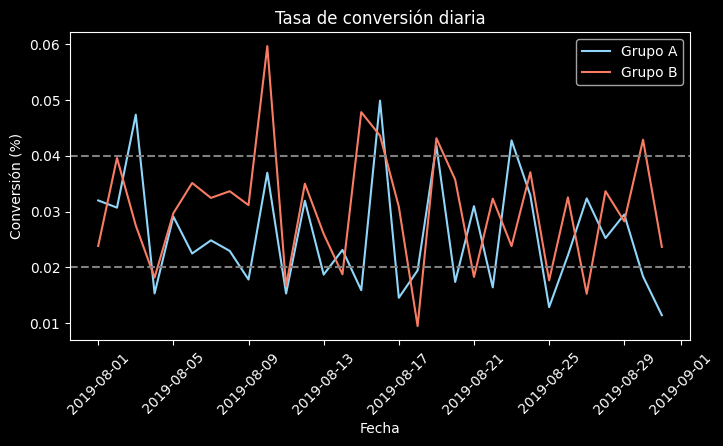

In [19]:
# tasa de conversión 
# dataframe número de órdenes por día
num_orders = (
    filtered_orders.groupby(['group', 'date'], as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)

# dataframe une órdenes por día y visitas por día
orders_visits_per_day = pd.merge(num_orders, visits, on=['group', 'date'])
orders_visits_per_day.rename(columns={'transaction_id':'num_orders'}, inplace=True)

# calcular tasa de conversión
orders_visits_per_day['conversion'] = orders_visits_per_day['num_orders'] / orders_visits_per_day['visits']

# ordernar cronológicamente
orders_visits_per_day = orders_visits_per_day.sort_values(by=['group', 'date'])

# gráfico de líneas: tasa de conversión diaria por grupo
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = orders_visits_per_day[orders_visits_per_day['group'] == grp]
    plt.plot(grp_data['date'], grp_data['conversion'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Tasa de conversión diaria')
plt.xlabel('Fecha')
plt.ylabel('Conversión (%)')
plt.axhline(0.04, color='grey', linestyle='--')
plt.axhline(0.02, color='grey', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Comentario
La tasa de conversión en ambos grupos se ha mantenido en torno al 3%. El día 10, el grupo "B" tuvo un incremento notable en la tasa de conversión, esto pudo deberse a que ese día la mayoría de las visitas resultaron en una compra.

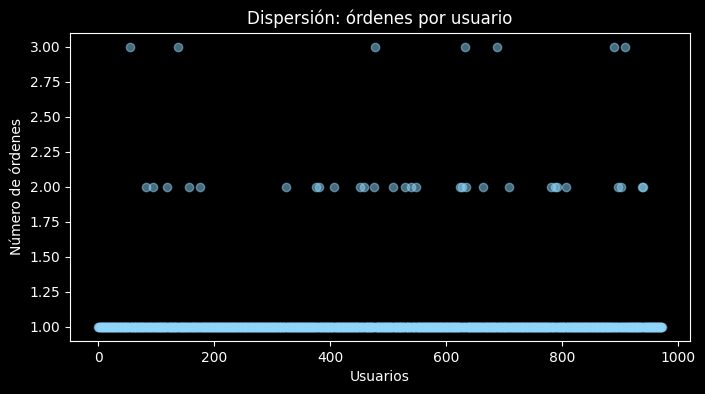

Percentil 95: 1.0
Percentil 99: 2.0


In [20]:
# dispersión del número de órdenes por usuario
# úmero de órdenes por usuario
orders_per_user = (
    filtered_orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)
orders_per_user.rename(columns={'transaction_id':'num_orders'}, inplace=True)

# gráfico de dispersión: órdenes por usuario
plt.figure(figsize=(8,4))
plt.scatter(range(len(orders_per_user)), orders_per_user['num_orders'], alpha=0.5, c='#8FD6FA')
plt.title('Dispersión: órdenes por usuario')
plt.xlabel('Usuarios')
plt.ylabel('Número de órdenes')
plt.show()

# percentiles 95 y 99
p95_orders = np.percentile(orders_per_user['num_orders'], 95)
p99_orders = np.percentile(orders_per_user['num_orders'], 99)

print(f'Percentil 95: {p95_orders}')
print(f'Percentil 99: {p99_orders}')

### Comentario
En cuanto al número de pedidos por usuario, el 95% de los usuarios han realizado 1 pedido, por lo que el 5% restante (2 o más pedidos) se considerará como _outlier_.

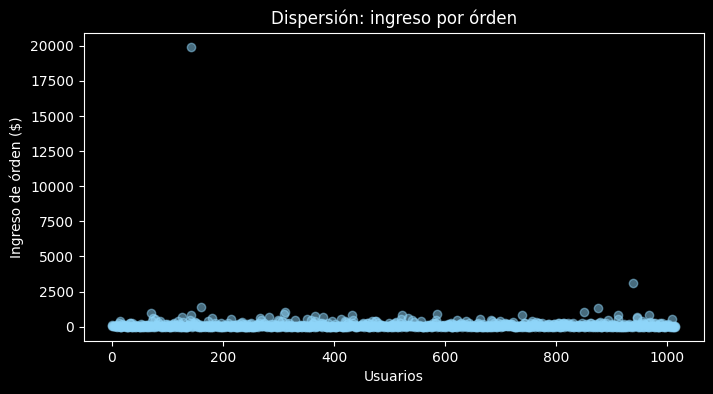

Percentil 95: 414.275
Percentil 99: 830.3


In [21]:
# dispersión del ingreso por órden
# úmero de órdenes por usuario
revenue_per_order = (
    filtered_orders.groupby('transaction_id', as_index=False)
    .agg({'revenue':'sum'})
)

# gráfico de dispersión: ingreso por órden
plt.figure(figsize=(8,4))
plt.scatter(range(len(revenue_per_order)), revenue_per_order['revenue'], alpha=0.5, c='#8FD6FA')
plt.title('Dispersión: ingreso por órden')
plt.xlabel('Usuarios')
plt.ylabel('Ingreso de órden ($)')
plt.show()

# percentiles 95 y 99
p95_revenue = np.percentile(revenue_per_order['revenue'], 95)
p99_revenue = np.percentile(revenue_per_order['revenue'], 99)

print(f'Percentil 95: {p95_revenue}')
print(f'Percentil 99: {p99_revenue}')

### Comentario
En cuanto al ingreso por órden, el 95% de los usuarios realizan pedidos de hasta $415, por lo que el 5% restante (pedidos mayores a $415) se considerará como _outlier_.

Con estos valores de _outliers_ definidos, se puede hacer una lista de usuarios con valores anormales en estas métricas y retirarlos para quedarnos con los usuarios "promedio".

## Evaluación de niveles de significancia

### Significancia con datos brutos

In [22]:
# significancia estadística en las métricas tamaño promedio de pedido y tasa de conversión por grupo
# significancia en tamaño promedio de pedido por grupo
group_a = filtered_orders.query('group == "A"')['revenue']
group_b = filtered_orders.query('group == "B"')['revenue']
# test U-MannWhitney
u_test = st.mannwhitneyu(group_a, group_b, alternative='two-sided')

# significancia en tasa de conversión por grupo
conversion = orders_visits_per_day.groupby('group').agg({'num_orders':'sum', 'visits':'sum'})
succes = conversion['num_orders']
trials = conversion['visits']
# test z
z_test = proportions_ztest(succes, trials)

# ajuste de FWER (tasa de error por familia)
# valores 'p' de los test
p_vals = [u_test.pvalue, z_test[1]]
# método 'Holm' para ajuste de alpha
holm_test = multipletests(p_vals, alpha=0.05, method='holm')

print(f'p_value de tamaño promedio: {u_test.pvalue}')
print(f'p_value de tasa de conversión: {z_test[1]}')
print('Significancia para tamaño promedio y tasa de conversión:', holm_test[0])

p_value de tamaño promedio: 0.8622329690015668
p_value de tasa de conversión: 0.01685138043470311
Significancia para tamaño promedio y tasa de conversión: [False  True]


### Comentario
Empleando los datos brutos no se ve una diferencia estadísticamente significativa en el tamaño promedio de pedidos entre los grupos. Por otro lado, si se observa una diferencia estadísticamente significativa en la tasa de conversión entre los grupos.

A continuación se va a realizar el filtrado de _outliers_ y comparar si el nivel de significancia se mantuvo o cambió.

### Significancia con datos filtrados

In [23]:
# filtrado de outliers
# definir condiciones "anormales"
abnormal_orders = orders_per_user[orders_per_user['num_orders'] > p95_orders]['visitor_id']
abnormal_revenue = filtered_orders[filtered_orders['revenue'] > p95_revenue]['visitor_id']
abnormal_users = pd.concat([abnormal_orders, abnormal_revenue], axis=0).drop_duplicates()

# filtrado de usuarios promedio
filtered_significance_orders = filtered_orders[np.logical_not(filtered_orders['visitor_id'].isin(abnormal_users))]
# filtrado de número de órdenes
filtered_num_orders = (
    filtered_significance_orders.groupby(['group', 'date'], as_index=False)
    .agg({'transaction_id':pd.Series.nunique})
)
# dataframe une órdenes por día y visitas por día
filtered_significance_visits = pd.merge(filtered_num_orders, visits, on=['group', 'date'])
filtered_significance_visits.rename(columns={'transaction_id':'num_orders'}, inplace=True)

In [24]:
# significancia estadística en las métricas tamaño promedio de pedido y tasa de conversión por grupo
# significancia en tamaño promedio de pedido por grupo
group_a = filtered_significance_orders.query('group == "A"')['revenue']
group_b = filtered_significance_orders.query('group == "B"')['revenue']
# test U-MannWhitney
u_test = st.mannwhitneyu(group_a, group_b, alternative='two-sided')

# significancia en tasa de conversión por grupo
conversion = filtered_significance_visits.groupby('group').agg({'num_orders':'sum', 'visits':'sum'})
succes = conversion['num_orders']
trials = conversion['visits']
# test z
z_test = proportions_ztest(succes, trials)

# ajuste de FWER (tasa de error por familia)
# valores 'p' de los test
p_vals = [u_test.pvalue, z_test[1]]
# método 'Holm' para ajuste de alpha
holm_test = multipletests(p_vals, alpha=0.05, method='holm')

print(f'p_value de tamaño promedio: {u_test.pvalue}')
print(f'p_value de tasa de conversión: {z_test[1]}')
print('Significancia para tamaño promedio y tasa de conversión:', holm_test[0])

p_value de tamaño promedio: 0.7711877309994826
p_value de tasa de conversión: 0.01619941344217632
Significancia para tamaño promedio y tasa de conversión: [False  True]


### Comentario
Después de realizar el filtrado de los _outliers_ nos podemos percatar que hubo ligeros cambios en el valor _p_ para ambas métricas, sin embargo, su significancia permanece igual en comparación con los datos brutos.

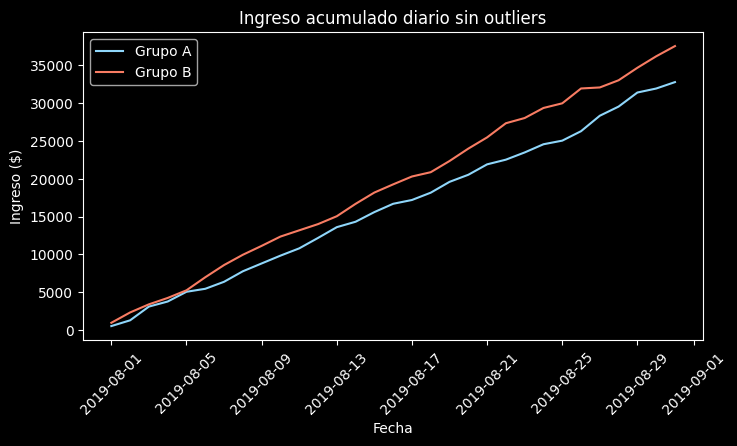

In [25]:
# ingreso acumulado diario por grupo
# dataframe ingresos acumulados diarios
daily_cumulative_revenue = filtered_significance_orders.groupby(['group', 'date'], as_index=False)['revenue'].sum()

# ordenar cronológicamente
daily_cumulative_revenue = daily_cumulative_revenue.sort_values(['group', 'date'])

# calcular ingreso acumulado diario
daily_cumulative_revenue['cumulative_revenue'] = daily_cumulative_revenue.groupby('group')['revenue'].cumsum()

# gráfico de líneas: ingreso acumulado diario
plt.figure(figsize=(8,4))
colors = {'A': '#8FD6FA', 'B': '#F87C63'}
for grp in ['A', 'B']:
    grp_data = daily_cumulative_revenue[daily_cumulative_revenue['group'] == grp]
    plt.plot(grp_data['date'], grp_data['cumulative_revenue'], label=f'Grupo {grp}', color=colors[grp])
plt.title('Ingreso acumulado diario sin outliers')
plt.xlabel('Fecha')
plt.ylabel('Ingreso ($)')
plt.legend()
plt.xticks(rotation=45)
plt.show()